In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, date
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
import sys
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from time import time

## Подготовка данных

In [2]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
df.head(5)

Name Platform  Year_of_Release         Genre Publisher  \
0                Wii Sports      Wii           2006.0        Sports  Nintendo   
1         Super Mario Bros.      NES           1985.0      Platform  Nintendo   
2            Mario Kart Wii      Wii           2008.0        Racing  Nintendo   
3         Wii Sports Resort      Wii           2009.0        Sports  Nintendo   
4  Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  Critic_Score  \
0     41.36     28.96      3.77         8.45         82.53          76.0   
1     29.08      3.58      6.81         0.77         40.24           NaN   
2     15.68     12.76      3.79         3.29         35.52          82.0   
3     15.61     10.93      3.28         2.95         32.77          80.0   
4     11.27      8.89     10.22         1.00         31.37           NaN   

   Critic_Count User_Score  User_Count Developer Rating  
0          51.0          8       322.0  Nintendo      E  
1           NaN        NaN         NaN       NaN    NaN  
2          73.0        8.3       709.0  Nintendo      E  
3          73.0          8       192.0  Nintendo      E  
4           NaN        NaN         NaN       NaN    NaN

In [3]:
df.shape[0]

16719

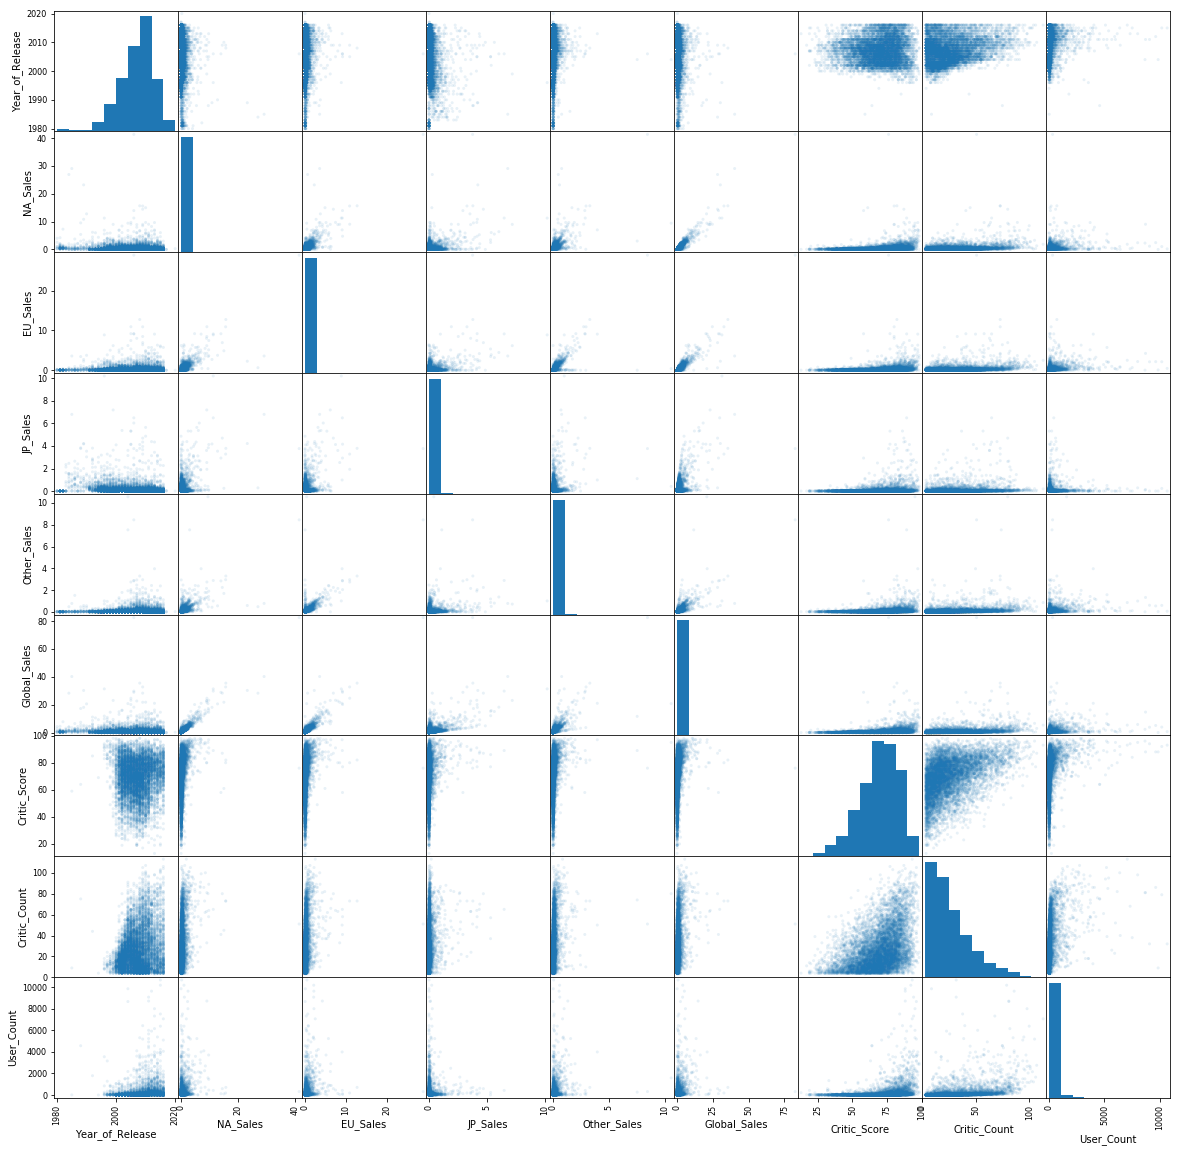

In [4]:
a = pd.plotting.scatter_matrix(df, alpha=0.1, figsize=(20, 20))

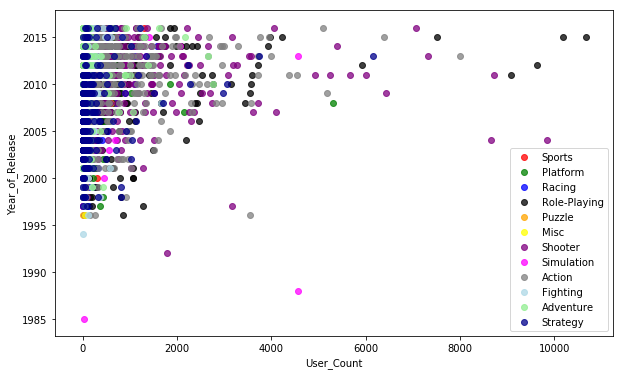

In [5]:
col1 = 'User_Count'
col2 = 'Year_of_Release'
plt.figure(figsize=(10, 6))

gen = ['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy']
clr = ['red', 'green', 'blue', 'black', 'orange', 'yellow',
       'purple', 'magenta', 'grey', 'lightblue', 'lightgreen',
       'darkblue']
for i in range(len(gen)):
    plt.scatter(df[col1][df['Genre'] == gen[i]],
                df[col2][df['Genre'] == gen[i]],
                alpha=0.75,
                color=clr[i],
                label=gen[i])
plt.xlabel(col1)
plt.ylabel(col2)
plt.legend(loc='best');

In [6]:
categorical_columns = [c for c in df.columns if df[c].dtype.name == 'object']
numerical_columns   = [c for c in df.columns if df[c].dtype.name != 'object']
print("Категориальные признаки: ", categorical_columns)
print("Количественные признаки: ", numerical_columns)

Категориальные признаки:  ['Name', 'Platform', 'Genre', 'Publisher', 'User_Score', 'Developer', 'Rating']
Количественные признаки:  ['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Count']


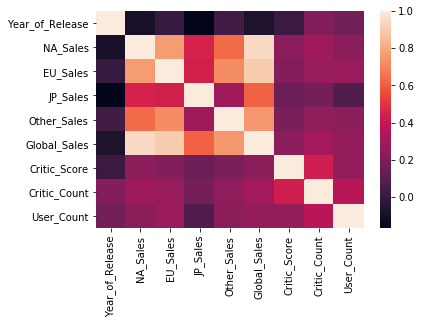

In [7]:

corr_matrix = df[['Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
                                        'Global_Sales', 'Critic_Score', 'Critic_Count', 'User_Count']].corr()
seaborn.heatmap(corr_matrix)

In [8]:
#удаляем строки,где не информации в столбцах 'name' и'Publisher'
df = df.dropna(axis=0,subset=['Name'])
df = df.dropna(axis=0,subset=['Publisher'])


In [9]:
#убираем выбросы
df = df.query('EU_Sales <= 25')
df = df.query('JP_Sales <= 5')

In [10]:
df.shape

(16653, 16)

In [11]:
gen = ['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc', 
'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure', 
'Strategy']

for genre in gen: 
    temp =  df.loc[(df['Genre'] == genre), 'Year_of_Release']
    df.loc[(df['Genre'] == genre), 'Year_of_Release'] = df.loc[(df['Genre'] == genre),
                                                               'Year_of_Release'].fillna(temp.median(axis=0), axis=0) 
    

In [12]:
for i in numerical_columns:
    if i == 'Year_of_Release':
        continue
    df[i] = df[i].fillna(df[i].median(axis=0), axis=0)

In [13]:
# все строковые значения заменяем на none для того чтобы перевести сериес в количественный признак 
for index, value in df['User_Score'].items():
    if value != None:
        try:
            #df['User_Score'].loc[index] = float(value)
            df.loc[index,'User_Score'] = float(value)
        except ValueError:
            df.loc[index,'User_Score'] = None
    else:
        continue        

In [14]:
df['User_Score'] = df['User_Score'].fillna(df['User_Score'].median(axis=0), axis=0)

In [15]:
#удаляем столбец 'Developer' 
del df['Developer']
#заполняем все пропуски в категориальных столбцах наиболее частым значением
df_describe = df.describe(include=[object])
df['Rating'] = df['Rating'].fillna(df_describe['Rating']['top'])

In [16]:
df_nonbin = pd.get_dummies(df['Genre'])


In [17]:
del df['Genre']

In [18]:
#проверяем,что данные есть во всех столбцах и их одинаковое кол-во
df.count(axis=0)

Name               16653
Platform           16653
Year_of_Release    16653
Publisher          16653
NA_Sales           16653
EU_Sales           16653
JP_Sales           16653
Other_Sales        16653
Global_Sales       16653
Critic_Score       16653
Critic_Count       16653
User_Score         16653
User_Count         16653
Rating             16653
dtype: int64

In [19]:
#Нормализация данных
df_numerical = df[numerical_columns]
df_numerical = (df_numerical - df_numerical.mean(axis=0)) / df_numerical.std(axis=0)


In [20]:
data = pd.concat((df_numerical, df_nonbin), axis=1)
df = pd.DataFrame(data)

In [35]:
from sklearn.model_selection import train_test_split


Xn = df.drop((['JP_Sales'] ), axis=1)   
Yn = df['JP_Sales']

X_train, X_test, Y_train, Y_test = train_test_split(Xn, Yn, test_size = 0.3, random_state = 11)

# Линейная Регрессия

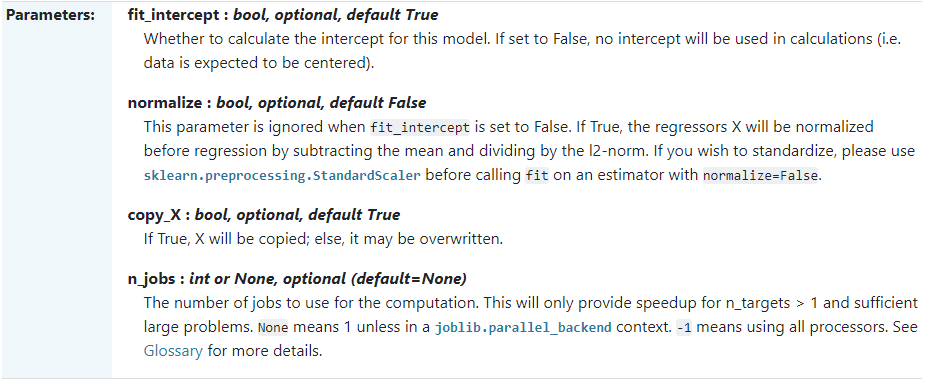

Коэффициент оценки r2 определяется, как (1 - u / v), где u - остаточная сумма квадратов ((y_true - y_pred) ** 2) .sum (),
а v - общая сумма квадратов ((y_true - y_true.mean ()) ** 2) .sum (). Наилучшая возможная оценка - 1,0,
она может быть отрицательной (поскольку модель может быть хуже).
Постоянная модель, которая всегда прогнозирует ожидаемое значение y, независимо от входных данных,
получит оценку R ^ 2 0,0.

In [36]:
from sklearn.metrics import mean_squared_error,r2_score

Fit_iner =[False, True]
for i in Fit_iner:
    t1 = time()
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, Y_train)

    Y_test_pred = model.predict(X_test)
    Y_train_pred = model.predict(X_train)

    t = time() - t1
    print('For fit_intercept is' ,i)
    print('Коэффициент оценки r2:', model.score(X_test, Y_test))# r2_score(Y_test, Y_test_pred)
    print('Среднеквадратическая ошибка регрессии test:', mean_squared_error(Y_test, Y_test_pred ))
    print('Среднеквадратическая ошибка регрессии train:', mean_squared_error(Y_train, Y_train_pred ))
    print('Время выполнения', t)
    print('-'*30)

For fit_intercept is False
Коэффициент оценки r2: 0.9996357983910763
Среднеквадратическая ошибка регрессии test: 0.0003890971192967975
Среднеквадратическая ошибка регрессии train: 0.00037521123080286306
Время выполнения 0.024958133697509766
------------------------------
For fit_intercept is True
Коэффициент оценки r2: 0.9996357983910763
Среднеквадратическая ошибка регрессии test: 0.0003890971192967975
Среднеквадратическая ошибка регрессии train: 0.00037521123080286306
Время выполнения 0.02492547035217285
------------------------------


На точность в данном случае может повлиять параметр fit_intercept,
однако его отключение ведет к незначительным изменениям в пределах 10^(-8).

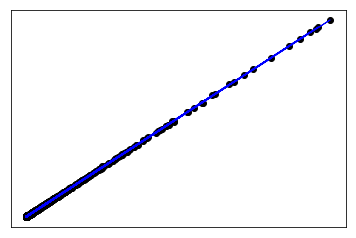

In [37]:
#На графике видна прямая линия, показывающая, как линейная регрессия пытается нарисовать прямую линию,
#которая наилучшим образом минимизирует остаточную сумму квадратов между наблюдаемыми откликами 
#в наборе данных и откликами, предсказанными линейным приближением
plt.scatter(Y_test, Y_test_pred,  color='black')
plt.plot(Y_test, Y_test_pred, color='blue', linewidth=1)

plt.xticks(())
plt.yticks(())

plt.show()

In [165]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: -19060537281.53536
slope: [ 1.37897377e-04 -2.63209472e+00 -1.62872397e+00 -6.03885741e-01
  5.00950950e+00  2.55582089e-04 -1.57564232e-05 -7.17647452e-05
  1.90605373e+10  1.90605373e+10  1.90605373e+10  1.90605373e+10
  1.90605373e+10  1.90605373e+10  1.90605373e+10  1.90605373e+10
  1.90605373e+10  1.90605373e+10  1.90605373e+10  1.90605373e+10]


# LassoLars
модель Лассо, реализованная с использованием алгоритма LARS

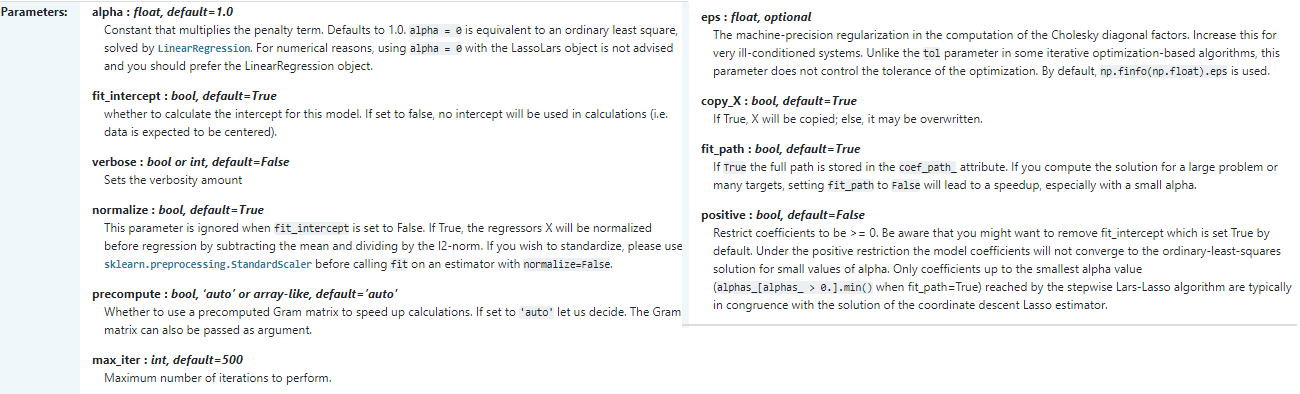

alpha=1.0, copy_X=True, eps=2.220446049250313e-16, fit_intercept=True,
          fit_path=True, max_iter=500, normalize=True, positive=False,
          precompute='auto', verbose=False

In [23]:
    params ={'alpha':[0, 10e-8, 10e-4, 1.0], 'fit_intercept' : [True, False],
                'eps':[2e-12, 1,  100],'max_iter':[10, 500, 1000] }
    for param in params:
        values = params[param]
        for value in values:
            t1 = time()
            alpha = 1.0
            eps = 2.220446049250313e-16
            fit_intercept = True
            max_iter = 500
            exec(f'{param} = value')
            
            model_lasso = linear_model.LassoLars(alpha=alpha, eps=eps, fit_intercept=fit_intercept, max_iter=max_iter)
            model_lasso.fit(X_train, Y_train)
            Y_test_pred = model_lasso.predict(X_test)
            Y_train_pred = model_lasso.predict(X_train)

            t = time() - t1

            print(f'For {param} is' , value)
            print('Коэффициент оценки r2:', model_lasso.score(X_test, Y_test))# r2_score(Y_test, Y_test_pred)
            print('Среднеквадратическая ошибка регрессии test:', mean_squared_error(Y_test, Y_test_pred ))
            print('Среднеквадратическая ошибка регрессии train:', mean_squared_error(Y_train, Y_train_pred ))
            print('Время выполнения', t)
            print('-'*30)

For alpha is 0
Коэффициент оценки r2: 0.9996357983910766
Среднеквадратическая ошибка регрессии test: 0.00038909711929637213
Среднеквадратическая ошибка регрессии train: 0.0003752112308028629
Время выполнения 0.532771110534668
------------------------------
For alpha is 1e-07
Коэффициент оценки r2: 0.9996358319727301
Среднеквадратическая ошибка регрессии test: 0.0003890612421221376
Среднеквадратическая ошибка регрессии train: 0.00037524621723757025
Время выполнения 0.019948482513427734
------------------------------
For alpha is 0.001
Коэффициент оценки r2: 0.365100666243916
Среднеквадратическая ошибка регрессии test: 0.67829876572493
Среднеквадратическая ошибка регрессии train: 0.674788717460147
Время выполнения 0.009994745254516602
------------------------------
For alpha is 1.0
Коэффициент оценки r2: -0.0001881929553113615
Среднеквадратическая ошибка регрессии test: 1.0685574558105837
Среднеквадратическая ошибка регрессии train: 0.9705574591451313
Время выполнения 0.019989013671875
-

In [77]:
 t1 = time()
alpha = 10e-8
eps = 2.220446049250313e-16
fit_intercept = False
max_iter = 10

model_lasso = linear_model.LassoLars(alpha=alpha, eps=eps, fit_intercept=fit_intercept, max_iter=max_iter)
model_lasso.fit(X_train, Y_train)
Y_test_pred = model_lasso.predict(X_test)
Y_train_pred = model_lasso.predict(X_train)

t = time() - t1

print(f'For alpha = 10e-8  eps = 2e-16  fit_intercept = Fale  max_iter = 10' )
print('Коэффициент оценки r2:', model_lasso.score(X_test, Y_test))# r2_score(Y_test, Y_test_pred)
print('Среднеквадратическая ошибка регрессии test:', mean_squared_error(Y_test, Y_test_pred ))
print('Среднеквадратическая ошибка регрессии train:', mean_squared_error(Y_train, Y_train_pred ))
print('Время выполнения', t)
print('-'*30)

For alpha = 10e-8  eps = 2e-16  fit_intercept = Fale  max_iter = 10
Коэффициент оценки r2: 0.9997630068508578
Среднеквадратическая ошибка регрессии test: 0.0002838208421127522
Среднеквадратическая ошибка регрессии train: 0.0002853929693671129
Время выполнения 0.019943714141845703
------------------------------


### Каждый цвет представляет отдельную особенность вектора коэффициентов,
### и это отображается как функция параметра регуляризации.

.

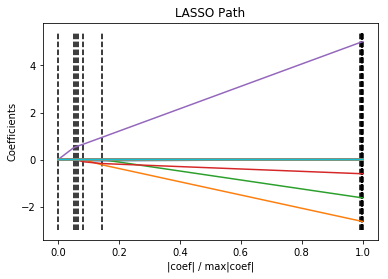

In [73]:
X = X_train.to_numpy(dtype=None, copy=True)
y = Y_train.to_numpy(dtype=None, copy=True)
_, _, coefs = linear_model.lars_path(X, y, method='lasso', verbose=True)
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()

# Ridge Regression

 #### Просто применяет обычный метод наименьших квадратов и накладывает штраф на размер коэффициентов
 #### т.е коэффициенты гребня минимизируют штрафную остаточную сумму квадратов
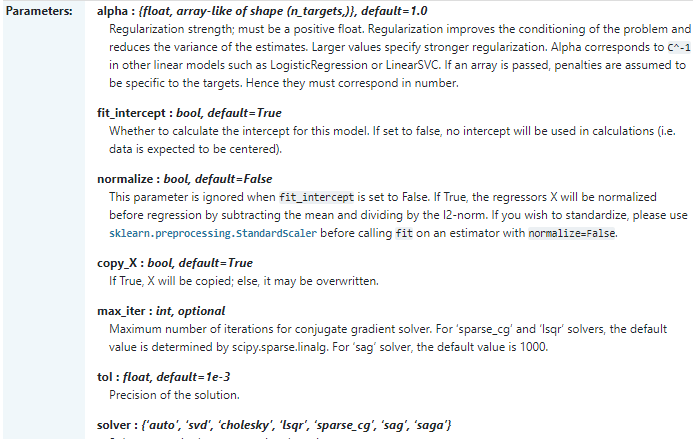

'auto' выбирает решатель автоматически в зависимости от типа данных

'svd' использует разложение по сингулярному значению X для вычисления коэффициентов Риджа. Более устойчив для сингулярных матриц, чем «холецкий»

'cholesky' использует стандартную функцию scipy.linalg.solve для получения решения

'sparse_cg' использует сопряженные градиенты, которые можно найти в scipy.sparse.linalg.cg. В качестве итерационного алгоритма этот решатель больше подходит, чем «холеский» для крупномасштабных данных (возможность устанавливать tolи max_iter).

'lsqr' использует специальную упорядоченную процедуру наименьших квадратов scipy.sparse.linalg.lsqr. Он самый быстрый и использует итеративную процедуру

'sag' использует стохастический спуск среднего градиента, а 'saga' использует его улучшенную, непредвзятую версию с именем SAGA. Оба метода также используют итеративную процедуру и часто работают быстрее, чем другие решатели, когда n_samples и n_features имеют большие значения. Быстрая сходимость 'sag' и 'saga' гарантируется только для объектов с приблизительно одинаковым масштабом(можно обработать данные с помощью скейлера из sklearn.preprocessing)

In [84]:
params ={'alpha':[10e-8, 1.0], 'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg']}
for param in params:
    values = params[param]
    for value in values:
        t1 = time()
        alpha = 1.0
        solver = 'auto'
        exec(f'{param} = value')
        
        model_ridge = linear_model.Ridge(alpha=alpha, fit_intercept=True, normalize=False,
                   copy_X=True, max_iter=None, tol=0.001, solver=solver, random_state=None)
        model_ridge.fit(X_train, Y_train)
        Y_test_pred = model_ridge.predict(X_test)
        Y_train_pred = model_ridge.predict(X_train)

        t = time() - t1

        print(f'For {param} is' , value)
        print('Коэффициент оценки r2:',  model_ridge.score(X_test, Y_test))# r2_score(Y_test, Y_test_pred)
        print('Среднеквадратическая ошибка регрессии test:', mean_squared_error(Y_test, Y_test_pred ))
        print('Среднеквадратическая ошибка регрессии train:', mean_squared_error(Y_train, Y_train_pred ))
        print('Время выполнения', t)
        print('-'*30)

For alpha is 1e-07
Коэффициент оценки r2: 0.9997636606995737
Среднеквадратическая ошибка регрессии test: 0.00028303779883151865
Среднеквадратическая ошибка регрессии train: 0.00028383639444701757
Время выполнения 0.01302957534790039
------------------------------
For alpha is 1.0
Коэффициент оценки r2: 0.9997467525261332
Среднеквадратическая ошибка регрессии test: 0.00030328687371761285
Среднеквадратическая ошибка регрессии train: 0.00029870427193869753
Время выполнения 0.019989728927612305
------------------------------
For solver is svd
Коэффициент оценки r2: 0.9997467525261337
Среднеквадратическая ошибка регрессии test: 0.00030328687371705687
Среднеквадратическая ошибка регрессии train: 0.0002987042719383046
Время выполнения 0.029984235763549805
------------------------------
For solver is cholesky
Коэффициент оценки r2: 0.9997467525261332
Среднеквадратическая ошибка регрессии test: 0.00030328687371761285
Среднеквадратическая ошибка регрессии train: 0.00029870427193869753
Время выпо

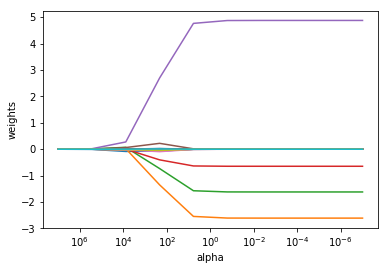

In [24]:
n_alphas = 10
alphas = np.logspace(-7, 7, n_alphas)

coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, Y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
#plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()
#почему линейные учаски весов

# Байесовская гребневая регрессия

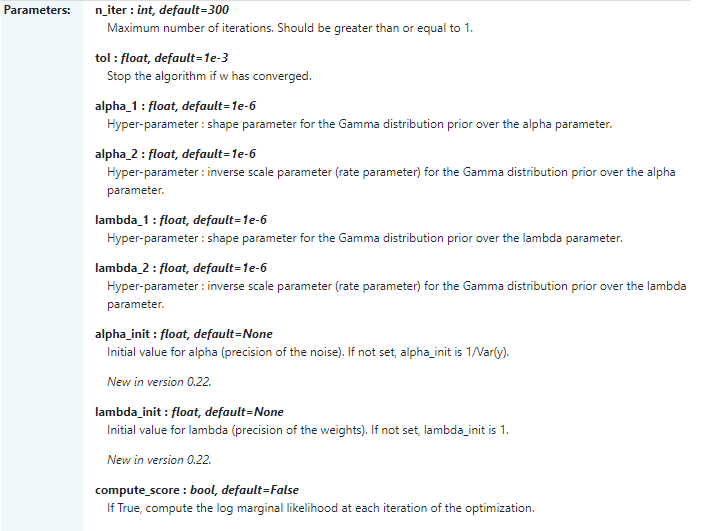

In [55]:
t = time()
model_bay = linear_model.BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
              fit_intercept=False, lambda_1=1e-02, lambda_2=1e-02, n_iter=10,
              normalize=False, tol=0.000001, verbose=False)
model_bay.fit(X_train, Y_train)
Y_test_pred = model_bay.predict(X_test)
Y_train_pred = model_bay.predict(X_train)

print('Коэффициент оценки r2:',  model_bay.score(X_test, Y_test))# r2_score(Y_test, Y_test_pred)
print('Среднеквадратическая ошибка регрессии test:', mean_squared_error(Y_test, Y_test_pred ))
print('Среднеквадратическая ошибка регрессии train:', mean_squared_error(Y_train, Y_train_pred ))
print('-'*30)
print(time() - t)

Коэффициент оценки r2: 0.9996357987151899
Среднеквадратическая ошибка регрессии test: 0.00038909677302813235
Среднеквадратическая ошибка регрессии train: 0.00037521123138390034
------------------------------
0.0418848991394043


In [56]:
Коэффициент оценки r2: 0.9996357986987939
Среднеквадратическая ошибка регрессии test: 0.000389096790544778
Среднеквадратическая ошибка регрессии train: 0.0003752112313267369
------------------------------
0.18319106101989746

SyntaxError: invalid syntax (<ipython-input-56-90a329ca284d>, line 1)